# Theory:

Discrete Update equations for RC:
$$
r_{i+1} = (1-\alpha) r_{i} + \alpha\tanh(W_{in} x_i + W r_i)
$$

Continuous Update equations for RC:
$$
\dot{r} = \gamma [-r + \tanh(W_{in}x + W r)] \\
$$

.. with explicit Euler:
$$
r_{i+1} = r_i + dt \gamma [-r_i + \tanh(W_{in}x_i + W r_i)] \\
r_{i+1} = (1-dt\gamma) r_i + dt\gamma\tanh(W_{in}x_i + W r_i)
$$

Time series described by an ODE:

$$
\dot{r} = f(r)
$$

... with explicit Euler:

$$
r_{i+1} = r_i + dt f(r_i)
$$

Two options to couple the ODE with the input:

1. Option: Couple on discrete update level - shift previous point:
$$
r_{i+1} = (W_{in} x_i + r_i) + dt f(W_{in} x_i + r_i)
$$
2. Option: Couple on discrete update level - shift the point only for the force:
$$
r_{i+1} = r_i + dt f(W_{in} x_i + r_i)
$$

3. Option: Couple on ODE level:
$$
\dot{r} = f(r) + W_{in} x \\
r_{i+1} = r_i + dt [f(r_i) + W_{in}x_i]
$$

# Imports:

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import rescomp

# new imports:
import rescomp.lyapunov_analysis as la

# Lorenz iterator:

In [32]:
# Lorenz parameters:
dt_L = 0.01
starting_point_L = np.array([0, 1, 0])

In [33]:
# lorenz iterator:

def data_creation_function(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("lorenz", dt, time_steps, starting_point)

def f_L(x):
    return data_creation_function(2, dt_L, x)[-1]

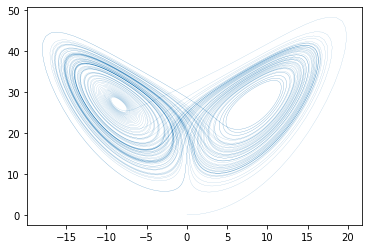

In [34]:
# test lorenz iterator:
time_steps = 10000

results = np.zeros((time_steps, 3))
results[0, :] = starting_point_L
for i in range(1, time_steps):
    x_last = results[i - 1, :]
    results[i, :] = f_L(x_last)

plt.plot(results[:, 0], results[:, 2], linewidth=0.1)

# Lorenz 96 Iterator:

### Plotting the pure Lorenz 96 system

In [95]:
# Lorenz 96 parameters:
dt_L96 = 0.01
dims = 500
np.random.seed(1)
starting_point_L96 = np.random.randn(dims)

In [96]:
# Lorenz96 iterator:

_lorenz_96 = rescomp.simulations._lorenz_96
iterator = rescomp.simulations._runge_kutta
f_L96 = lambda x: iterator(_lorenz_96, dt_L96, x)

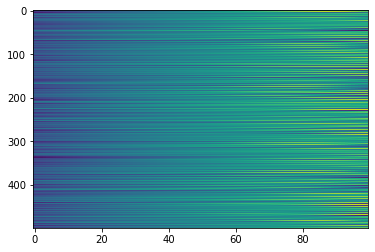

In [97]:
time_steps_L96 = 100
results_L96 = np.zeros((time_steps_L96, dims))

results_L96[0, :] = starting_point_L96
for i in range(1, time_steps_L96):
    x_last = results_L96[i - 1, :]
    results_L96[i, :] = f_L96(x_last)

plt.imshow(results_L96.T, aspect="auto")
# plt.xlim(0, 100)

# Couplings:

In [142]:
# Parameters:
time_steps = 10000
disc_timesteps = 100

# test iterator:
w_in_scale = 0.2
np.random.seed(2)
w_in = np.random.uniform(low=-w_in_scale,
                         high=w_in_scale,
                         size=(dims, 3))

# take every nth reservoir value:
nth = 5

In [129]:
starting_point_L96_use = starting_point_L96
starting_point_L_use = starting_point_L

# discard the starting timesteps:
for i in range(disc_timesteps):
    starting_point_L96_use = f_L96(starting_point_L96_use)
    starting_point_L_use = f_L(starting_point_L_use)

In [130]:
# L96
results_L96 = np.zeros((time_steps, dims))
results_L96[0, :] = starting_point_L96_use

# L96 coupled
results_L96_coupled = results_L96.copy()

# L:
results_L = np.zeros((time_steps, 3))
results_L[0, :] = starting_point_L_use

## 1. Option: Iterator based coupling - shift previous point:

In [75]:
for i in range(1, time_steps):
    # baseline iteration:
    results_L96[i, :] = f_L96(results_L96[i - 1, :])

    x_last_res = results_L96_coupled[i - 1, :]
    x_last_in = results_L[i - 1, :]

    x_add = w_in.dot(x_last_in)

    inp = x_last_res + x_add
    
    results_L96_coupled[i, :] = f_L96(inp)
    results_L[i, :] = f_L(x_last_in)

## 2. Option: Iterator based coupling - only shift force:

In [88]:
for i in range(1, time_steps):
    # baseline iteration:
    results_L96[i, :] = _lorenz_96(results_L96[i - 1, :])*dt_L96 + results_L96[i - 1, :]

    x_last_res = results_L96_coupled[i - 1, :]
    x_last_in = results_L[i - 1, :]

    x_add = w_in.dot(x_last_in)

    inp = x_last_res + x_add
    results_L96_coupled[i, :] = _lorenz_96(inp)*dt_L96 + results_L96_coupled[i - 1, :]
    results_L[i, :] = f_L(x_last_in)

C:\Users\Dennis\Documents\GitHub\rescomp\rescomp\simulations.py:335: RuntimeWarning: overflow encountered in double_scalars
  derivative[0] = (x[1] - x[system_dimension - 2]) * x[system_dimension - 1] - x[0]
C:\Users\Dennis\Documents\GitHub\rescomp\rescomp\simulations.py:336: RuntimeWarning: overflow encountered in double_scalars
  derivative[1] = (x[2] - x[system_dimension - 1]) * x[0] - x[1]
C:\Users\Dennis\Documents\GitHub\rescomp\rescomp\simulations.py:337: RuntimeWarning: overflow encountered in double_scalars
  derivative[system_dimension - 1] = (x[0] - x[system_dimension - 3]) * x[system_dimension - 2] - \
C:\Users\Dennis\Documents\GitHub\rescomp\rescomp\simulations.py:342: RuntimeWarning: overflow encountered in double_scalars
  derivative[i] = (x[i + 1] - x[i - 2]) * x[i - 1] - x[i]
C:\Users\Dennis\Documents\GitHub\rescomp\rescomp\simulations.py:335: RuntimeWarning: invalid value encountered in double_scalars
  derivative[0] = (x[1] - x[system_dimension - 2]) * x[system_dimens

## 3. Option: ODE based coupling:

In [131]:
# Coupled ODE:
_lorenz_96_coupled = lambda r, x: _lorenz_96(r) + w_in.dot(x)

In [132]:
for i in range(1, time_steps):
    # baseline iteration:
    results_L96[i, :] = _lorenz_96(results_L96[i - 1, :])*dt_L96 + results_L96[i - 1, :]

    x_last_in = results_L[i - 1, :]
    x_last_res = results_L96_coupled[i - 1, :]

    results_L96_coupled[i, :] = _lorenz_96_coupled(x_last_res, x_last_in)*dt_L96 + x_last_res

    results_L[i, :] = f_L(x_last_in)

## Plotting:

Text(0.5, 1.0, 'L96 coupled - L96')

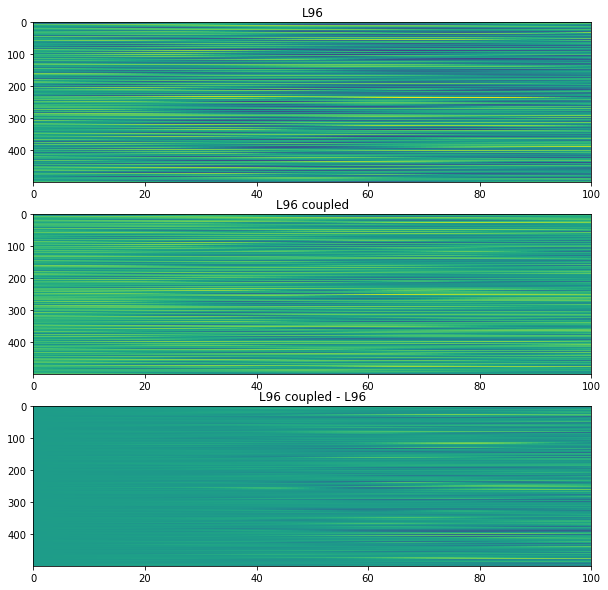

In [133]:
xlim = (0, 100)
# xlim = None

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

ax = axs[0]
ax.imshow(results_L96.T, aspect="auto")
ax.set_xlim(xlim)
ax.set_title("L96")

ax = axs[1]
ax.imshow(results_L96_coupled.T, aspect="auto")
ax.set_xlim(xlim)
ax.set_title("L96 coupled")

ax = axs[2]
ax.imshow((results_L96_coupled - results_L96).T, aspect="auto")
ax.set_xlim(xlim)
ax.set_title("L96 coupled - L96")

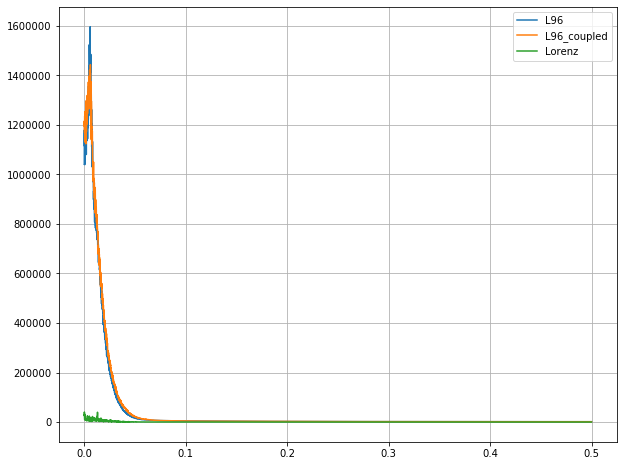

In [134]:
# Explore frequencies:
plt.figure(figsize=(10, 8))

x, y = rescomp.measures.fourier_spectrum(results_L96)
plt.plot(x, y, label="L96")

x, y = rescomp.measures.fourier_spectrum(results_L96_coupled)
plt.plot(x, y, label="L96_coupled")

x, y = rescomp.measures.fourier_spectrum(results_L)
plt.plot(x, y, label="Lorenz")

plt.grid()
plt.legend()

## Train and Test:

In [135]:
results_L.shape

(10000, 3)

In [136]:
# Try to fit the coupled to the output:
sync_steps = 100
train_steps = 6000
test_steps = 1000

x_sync = results_L96_coupled[: sync_steps, :]
y_sync = results_L[: sync_steps, :]

x_train = results_L96_coupled[sync_steps: sync_steps + train_steps, :]
y_train = results_L[sync_steps: sync_steps + train_steps, :]

x_test = results_L96_coupled[sync_steps + train_steps: sync_steps + train_steps + test_steps, :]
y_test = results_L[sync_steps + train_steps: sync_steps + train_steps + test_steps, :]

x_test.shape

(1000, 500)

In [137]:
# Train:
from sklearn.linear_model import Ridge

model = Ridge(alpha=0.01)
model.fit(x_train, y_train)

Ridge(alpha=0.01)

In [138]:
y_test_pred = model.predict(x_test)
y_test_pred

array([[  8.78683092,   4.73038794,  38.10570737],
       [  8.27621669,   4.7589515 ,  38.48614439],
       [  7.78701569,   4.78680322,  38.86605428],
       ...,
       [ 23.41125393,  22.33169966, -32.51859134],
       [ 22.71557716,  21.65569751, -27.17295047],
       [ 21.99527275,  20.84024702, -21.55797419]])

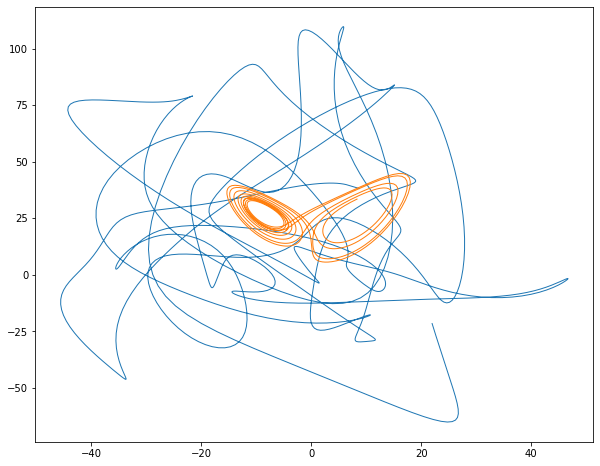

In [139]:
plt.figure(figsize=(10, 8))
plt.plot(y_test_pred[:, 0], y_test_pred[:, 2], linewidth=1)
plt.plot(y_test[:, 0], y_test[:, 2], linewidth=1)

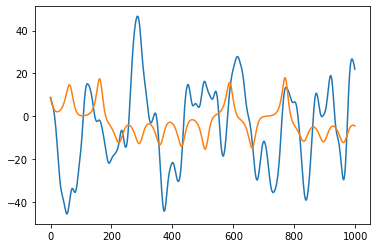

In [140]:
plt.plot(y_test_pred[:, 0])
plt.plot(y_test[:, 0])

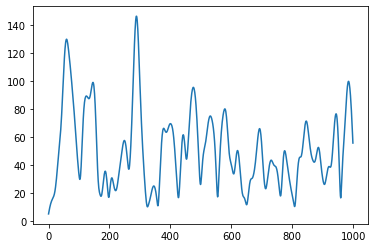

In [141]:
error = np.linalg.norm(y_test_pred - y_test, axis=1)
plt.plot(error)

# KS iterator:


In [ ]:
dims = 200
L = 100

def data_creation_function_ks(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("kuramoto_sivashinsky_custom", dt, time_steps, starting_point, fft_type="scipy", dimensions=dims, system_size=L)

dt_ks = 0.5
def f_ks(x):
    return data_creation_function_ks(2, dt_ks, x)[-1]

In [ ]:
# test KS iterator:
time_steps = 1000
results_ks = np.zeros((time_steps, dims))

# default starting point
x = L * np.transpose(np.conj(np.arange(1, dims + 1))) / dims
starting_point = np.cos(2 * np.pi * x / L) * (1 + np.sin(2 * np.pi * x / L))

results_ks[0, :] = starting_point
for i in range(1, time_steps):
    x_last = results_ks[i - 1, :]
    results_ks[i, :] = f_ks(x_last)

plt.imshow(results_ks.T, aspect="auto")

## Coupling of both systems:


In [0]:
w_in_scale = 0.0001
w_in = np.random.uniform(low=-w_in_scale,
                         high=w_in_scale,
                         size=(dims, 3))

In [0]:
# test KS iterator:
time_steps = 2000

# ks
results_ks = np.zeros((time_steps, dims))
# default starting point
x = L * np.transpose(np.conj(np.arange(1, dims + 1))) / dims
starting_point = np.cos(2 * np.pi * x / L) * (1 + np.sin(2 * np.pi * x / L))
results_ks[0, :] = starting_point

# lorenz:
results = np.zeros((time_steps, 3))
results[0, :] = np.array([0, 1, 0])

for i in range(1, time_steps):
    x_last = results_ks[i - 1, :]
    x_last_in = results[i-1, :]
    x_add = w_in.dot(x_last_in)
    # if i > 1000:
    #     x_add = 0
    results_ks[i, :] = f_ks(x_last + x_add)
    results[i, :] = f(x_last_in)
plt.imshow(results_ks.T, aspect="auto")

In [ ]:
plt.plot(results[:, 0], results[:, 1], linewidth=0.1)
